In [1]:
import os
import sys
import numpy as np
import nibabel as nib
import psutil
from time import time
import matplotlib.pyplot as plt
#from tqdm import tqdm
%matplotlib inline
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import h5py

In [2]:
file_ch2 = '/oak/stanford/groups/trc/data/Ashley2/imports/20210802/fly1_40s-011/ch2_stitched.nii'
file_ch1 = '/oak/stanford/groups/trc/data/Ashley2/imports/20210802/fly1_40s-011/ch1_stitched.nii'

In [3]:
ch2_img = nib.load(file_ch2) # this loads a proxy
ch1_img = nib.load(file_ch1)

In [12]:
dims = ch2_img.header.get_data_shape()
print(dims)

(476, 236, 29, 6993)


In [13]:
## first make an h5py file
save_path = '/oak/stanford/groups/trc/data/Brezovec'
if os.path.exists(save_path):
    print('folder there')
else:
    os.makedirs(save_path)
    
save_file_ch1 = os.path.join(save_path, 'test_MOCO_ch1.h5')
save_file_ch2 = os.path.join(save_path, 'test_MOCO_ch2.h5')

folder there


In [14]:
with h5py.File(save_file_ch1, 'w') as f_ch1:
    dset_ch1 = f_ch1.create_dataset('data', (*dims[:3],0), maxshape=(*dims[:3],None), dtype='float32')
print('created empty hdf5 file ch1')

with h5py.File(save_file_ch2, 'w') as f_ch2:
    dset_ch2 = f_ch2.create_dataset('data', (*dims[:3],0), maxshape=(*dims[:3],None), dtype='float32')
    #zscore_ch2 = f_ch2.create_dataset('zscore', (*dims[:3],0), maxshape=(*dims[:3],None), dtype='float32')
print('created empty hdf5 file ch2')

created empty hdf5 file ch1
created empty hdf5 file ch2


In [15]:
## calculate meanbrain
small_brain_size = 3  #use for testing
meanbrain = np.zeros(dims[:3])

#for i in range(dims[-1]):
for i in range(small_brain_size):
    meanbrain += ch1_img.dataobj[...,i]
meanbrain = meanbrain/small_brain_size


In [16]:
#make fixed moco
fixed = ants.from_numpy(np.asarray(meanbrain, dtype='float32'))


In [17]:
## loop over vols to get moco (use small_brain_size for test)

i = 0
vol = ch1_img.dataobj[...,i]

moving = ants.from_numpy(np.asarray(vol, dtype='float32'))

# Motion correct
print('moco start')
moco = ants.registration(fixed,moving,type_of_transform='SyN')
moco_out = moco['warpedmovout'].numpy()
transformlist = moco['fwdtransforms']
print('moco finish')

##also make ch2 warped brain correction using transforms
#if ch2_brain_file is not None: 
ch2_img = nib.load(file_ch2) # this loads a proxy
ch2_vol = ch2_img.dataobj[...,i]
ch2_moving = ants.from_numpy(np.asarray(ch2_vol, dtype='float32'))
#moco_ch2 = ants.apply_transforms(meanbrain, ants.from_numpy(ch2_moving), transformlist).numpy()
#moco_ch2 = ants.apply_transforms(meanbrain, ch2_moving, transformlist).numpy()
moco_ch2 = ants.apply_transforms(meanbrain, ch2_moving, transformlist)
#moco_ch2 = moco_ch2.numpy()

# # Append to hdf5 file
# with h5py.File(save_file_ch1, 'a') as f_ch1:

#     # Increase hdf5 size by one brain volume
#     current_num_vol = f_ch1['data'].shape[-1] # this is the last axis, which is time
#     new_num_vol = current_num_vol + 1 # will want one more volume
#     f_ch1['data'].resize(new_num_vol,axis=3) # increase size by one volume

#     # Append to hdf5 file
#     f_ch1['data'][...,-1] = moco_out  ##

# # Append to hdf5 file
# with h5py.File(save_file_ch2, 'a') as f_ch2:

#     # Increase hdf5 size by one brain volume
#     current_num_vol = f_ch2['data'].shape[-1] # this is the last axis, which is time
#     new_num_vol = current_num_vol + 1 # will want one more volume
#     f_ch2['data'].resize(new_num_vol,axis=3) # increase size by one volume

#     # Append to hdf5 file
#     f_ch2['data'][...,-1] = moco_ch2  ##




moco start
moco finish


In [24]:
meanbrain

array([[[ 16.66666667,  53.66666667,  17.66666667, ...,  21.        ,
          14.33333333,  14.66666667],
        [ 18.33333333,  22.66666667,   4.        , ...,  13.        ,
          37.33333333,  21.66666667],
        [ 20.33333333,  40.        ,  24.33333333, ...,  24.33333333,
          19.33333333,  12.        ],
        ...,
        [ 12.33333333,  10.33333333,   7.33333333, ...,  12.66666667,
          29.33333333,  20.        ],
        [ 22.33333333,  23.33333333,  26.33333333, ...,  18.66666667,
          26.33333333,  31.33333333],
        [ 14.66666667,  35.        ,  14.        , ...,  23.33333333,
          13.66666667,  25.66666667]],

       [[ 37.        ,  10.        ,  14.33333333, ...,  19.33333333,
          15.33333333,  28.33333333],
        [ 13.        ,  33.66666667,   9.66666667, ...,  18.        ,
          27.66666667,  29.        ],
        [ 19.        ,  25.66666667,  11.33333333, ...,  53.66666667,
           3.66666667,  20.33333333],
        ...,


In [22]:
transformlist

['/tmp/tmpr4ykjdpe1Warp.nii.gz', '/tmp/tmpr4ykjdpe0GenericAffine.mat']

In [23]:
moco_ch2

1

In [20]:
moco_out.shape

(476, 236, 29)

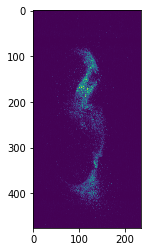

In [21]:
plt.imshow(moco_out[:,:,10])

In [113]:
memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
print('Current memory usage: {:.2f}GB'.format(memory_usage))

Current memory usage: 1.17GB


In [ ]:
##zscore section

In [97]:
# open h5py

#I am not sure how much memory this will take and if it loads a proxy or if it actually puts the whole thing in memory
#if it puts the whole thing in memory I'll need to just open part of it and run the rest of the code within the with:
#seems to take some memory but not a lot. .12GB to load the other channel, but x 700 for the rest of the brain and its 84GB so it does load the whole thing probably or at least enough to mess things up
#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

with h5py.File(save_file_ch2, 'r') as hf:
    data_ch1 = hf['zscore']
    #test_get = hf['data']  #I think the [:] opens the dataset? I think it could also be done with [()]
    #data_ch1 = hf['data'][:][...,0] #can slice like this to get first volume only
    print(np.shape(data_ch1))
#print(data_ch1.shape)
# print(type(data_ch1))
print(data_ch1)
print(test_get)

(476, 236, 29, 10)
<Closed HDF5 dataset>
[]


In [73]:
0.12*700

84.0

In [109]:

memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
print('Current memory usage: {:.2f}GB'.format(memory_usage))

Current memory usage: 1.15GB


In [93]:
## find a way to get dims of h5py without opening it
dims = np.shape(data_ch1)
print(dims)

(476, 236, 29, 0)


In [56]:


##calculate meanbrain of moco brain
dims = np.shape(data_ch1)
print(dims)
meanbrain = np.zeros(dims[:3])
print(np.shape(meanbrain))
print(np.shape(data_ch1[:,:,:,0]))
print(dims[:3])
for i in range(dims[-1]):  
    meanbrain += data_ch1[:,:,:,i]
meanbrain = meanbrain/small_brain_size
print('smeanbrain', np.shape(meanbrain))

##calculate STD of moco brain
total = 0
for i in range(dims[-1]):
    s = (data_ch1[:,:,:,i] - meanbrain)**2
    total = s + total
final_std = np.sqrt(total/len(data_ch1[-1]))
print('s-std', np.shape(final_std))


(476, 236, 29, 10)
(476, 236, 29)
(476, 236, 29)
(476, 236, 29)
smeanbrain (476, 236, 29)
s-std (476, 236, 29)


In [76]:
#run zscore
for i in range(dims[-1]):
    each_zscore = (data_ch1[:,:,:,i] - meanbrain)/final_std
    
    #save each zscore --use the same ch2 file and make a new key--need to set up the new key like did for moco
    
    
    with h5py.File(save_file_ch2, 'a') as f_ch2:

        # Increase hdf5 size by one brain volume
        current_num_vol = f_ch2['zscore'].shape[-1] # this is the last axis, which is time
        new_num_vol = current_num_vol + 1 # will want one more volume
        f_ch2['zscore'].resize(new_num_vol,axis=3) # increase size by one volume

        # Append to hdf5 file
        f_ch2['zscore'][...,-1] = each_zscore

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
## now do it inside the opening of the file 
## It's hard to know how to find the dims of the data
#somehow I broke my data so it is only 1 volume..

#make file to save into
# with h5py.File(save_file_ch2, 'w') as f_ch2:
#     zscore_ch2 = f_ch2.create_dataset('zscore test', (*dims[:3],0), maxshape=(*dims[:3],None), dtype='float32')
# print('created empty hdf5 file ch2')

#this is actually pretty fast for 10 volumes, I' not going to worry about doing chunks

with h5py.File(save_file_ch2, 'a') as hf:  #I chagned this to a so I can read and write. Hopefully not a bad idea
    #data_ch1 = hf['data'][:]
    data_ch1 = hf['data']  #I think the [:] opens the dataset? I think it could also be done with [()]
    #data_ch1 = hf['data'][:][...,0] #can slice like this to get first volume only
    dims = np.shape(data_ch1)
    print(dims)
    
    #make file to save zscore in (this errors if done more than once)
    zscore_ch1 = hf.create_dataset('zscore test', (*dims[:3],0), maxshape=(*dims[:3],None), dtype='float32')


    #find meanbrain (I want to run through the whole thing before moving to the zscore)
    for i in range(dims[-1]):  
        meanbrain += data_ch1[:,:,:,i]
    meanbrain = meanbrain/small_brain_size

    #find std
    total = 0
    for i in range(dims[-1]):
        s = (data_ch1[:,:,:,i] - meanbrain)**2
        total = s + total
    final_std = np.sqrt(total/len(data_ch1[-1]))


    #calculate zscore
    for i in range(dims[-1]):
        each_zscore = (data_ch1[:,:,:,i] - meanbrain)/final_std

        #save zscore
        # Increase hdf5 size by one brain volume
        current_num_vol = hf['zscore test'].shape[-1] # this is the last axis, which is time
        new_num_vol = current_num_vol + 1 # will want one more volume
        hf['zscore test'].resize(new_num_vol,axis=3) # increase size by one volume

        # Append to hdf5 file
        hf['zscore test'][...,-1] = each_zscore
    

(476, 236, 29, 10)
